# 使用 AlphaGenome 进行批量分析

本 notebook 展示如何对多个基因组区域或变异进行批量分析。

## 您将学到：
- 准备批量输入数据（CSV 文件）
- 对多个变异运行预测
- 在批量任务期间监控 API 配额
- 汇总和可视化批量结果

---

## 1. 导入库

In [1]:
# AlphaGenome 库
from alphagenome.data import genome
from alphagenome.models import dna_client

# 可视化
import matplotlib.pyplot as plt

# 数据处理
import pandas as pd
from pathlib import Path

# 我们的自定义工具
import sys
sys.path.insert(0, '/opt/alphagenome_packages')
from alphagenome_tools import (
    quick_plot, 
    monitor_api_quota,
    batch_predict_variants,
    batch_predict_sequences,
    load_variants_from_csv,
    export_to_csv,
    export_to_excel
)
from alphagenome_tools.visualization import plot_batch_summary

print("✓ 所有库已成功导入")

/usr/local/lib/python3.10/dist-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


✓ 所有库已成功导入


## 2. 连接到 AlphaGenome 并检查配额

In [2]:
import os

# 从环境变量获取 API 密钥
api_key = os.environ.get('ALPHAGENOME_API_KEY')
if not api_key:
    raise ValueError(
        "环境变量中未找到 ALPHAGENOME_API_KEY！"
        "请确保在 docker-compose.yml 中已设置"
    )

# 创建模型连接
model = dna_client.create(api_key=api_key)

print("✓ AlphaGenome 连接已建立")

# 检查 API 配额
monitor = monitor_api_quota()
print(f"API 状态: {monitor}")

✓ AlphaGenome 连接已建立
API 状态: API Usage: 24/1,000,000 calls (999,976 remaining)


## 3. 准备批量输入数据

### 选项 A: 使用示例数据

In [3]:
# 从共享数据加载示例变异
example_csv = Path('/shared/data/examples/known_variants.csv')

if example_csv.exists():
    variants = load_variants_from_csv(example_csv)
    print(f"✓ 从 {example_csv} 加载了 {len(variants)} 个示例变异")
else:
    # 创建示例变异
    print("正在创建演示用示例变异...")
    variants = [
        genome.Variant('chr22', 36201698, 'A', 'C'),
        genome.Variant('chr22', 36202000, 'G', 'T'),
        genome.Variant('chr22', 36202500, 'C', 'G'),
        genome.Variant('chr21', 33000000, 'A', 'G'),
        genome.Variant('chr21', 33000500, 'T', 'C'),
    ]
    print(f"✓ 创建了 {len(variants)} 个示例变异")

正在创建演示用示例变异...
✓ 创建了 5 个示例变异


### 选项 B: 加载您自己的 CSV 文件

In [4]:
# 要使用您自己的变异，请创建包含以下列的 CSV：
# chromosome,position,reference_bases,alternate_bases
#
# 示例：
# chromosome,position,reference_bases,alternate_bases
# chr22,36201698,A,C
# chr22,36202000,G,T
#
# 然后加载它：

# variants = load_variants_from_csv('path/to/your/variants.csv')

print("取消注释上面的代码以加载您自己的 CSV 文件")

取消注释上面的代码以加载您自己的 CSV 文件


### 选项 C: 以编程方式创建变异

In [5]:
# 您也可以通过编程方式创建变异
# 例如，在特定区域生成变异：

# def generate_variants_in_region(chrom, start, end, count=10):
#     variants = []
#     positions = np.random.randint(start, end, count)
#     for pos in positions:
#         variants.append(genome.Variant(
#             chromosome=chrom,
#             position=pos,
#             reference_bases='A',
#             alternate_bases='G'
#         ))
#     return variants

# variants = generate_variants_in_region('chr22', 36000000, 36500000, count=20)

print("取消注释以通过编程方式生成变异")

取消注释以通过编程方式生成变异


## 4. 预览您的变异

In [6]:
# 转换为 DataFrame 以便查看
variants_df = pd.DataFrame([{
    'chromosome': v.chromosome,
    'position': v.position,
    'reference': v.reference_bases,
    'alternate': v.alternate_bases
} for v in variants])

print(f"\n要分析的变异总数: {len(variants)}")
print("\n前 5 个变异:")
display(variants_df.head())


要分析的变异总数: 5

前 5 个变异:


,chromosome,position,reference,alternate
0,chr22,36201698,A,C
1,chr22,36202000,G,T
2,chr22,36202500,C,G
3,chr21,33000000,A,G
4,chr21,33000500,T,C


## 5. 运行批量预测

现在让我们对所有变异运行预测并跟踪进度。

In [7]:
# 设置分析参数
# 必须使用模型支持的长度: 16384, 131072, 524288, 或 1048576
window_size = 131072  # 每个变异周围 ~131kb 窗口
ontology_terms = ['UBERON:0001157']  # 可选: 组织类型
requested_outputs = [dna_client.OutputType.RNA_SEQ]

print(f"开始对 {len(variants)} 个变异进行批量分析...")
print(f"窗口大小: {window_size:,} bp (模型支持)")
print(f"大约需要 {len(variants)} 次 API 调用")
print("\n请稍候...\n")

# 运行批量预测
results_df = batch_predict_variants(
    variants=variants,
    model=model,
    window_size=window_size,  # 传递 window_size 参数
    ontology_terms=ontology_terms,
    requested_outputs=requested_outputs,
    show_progress=True,  # 显示进度条
    monitor=True  # 跟踪 API 使用情况
)

print("\n✓ 批量分析完成！")

开始对 5 个变异进行批量分析...
窗口大小: 131,072 bp (模型支持)
大约需要 5 次 API 调用

请稍候...



Predicting variants: 100%|██████████| 5/5 [00:04<00:00,  1.03it/s]
2026-02-09 06:01:27,986 - alphagenome_tools.helpers - INFO - Completed 5 variant predictions (5 successful)



✓ 批量分析完成！


## 6. 检查结果和 API 使用情况

In [8]:
# 显示摘要统计
print("\n=== 批量分析摘要 ===")
print(f"变异总数: {len(results_df)}")
print(f"成功: {results_df['success'].sum()}")
print(f"失败: {(~results_df['success']).sum()}")

# 检查 API 配额
monitor = monitor_api_quota()
print(f"\n{monitor}")

# 如有失败的预测，显示它们
if (~results_df['success']).any():
    print("\n失败的预测:")
    display(results_df[~results_df['success']])


=== 批量分析摘要 ===
变异总数: 5
成功: 5
失败: 0

API Usage: 29/1,000,000 calls (999,971 remaining)


## 7. 可视化批量结果

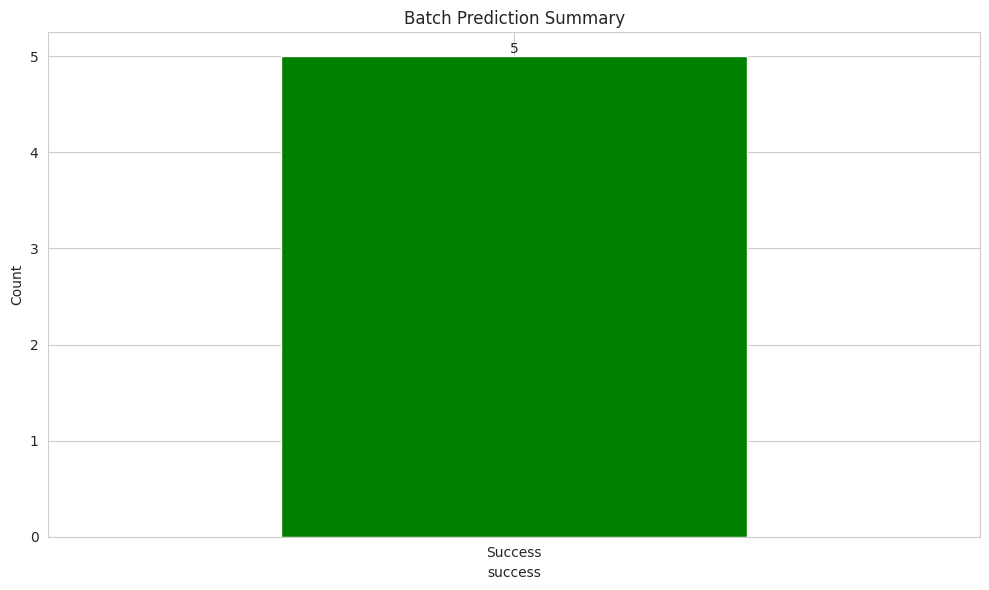

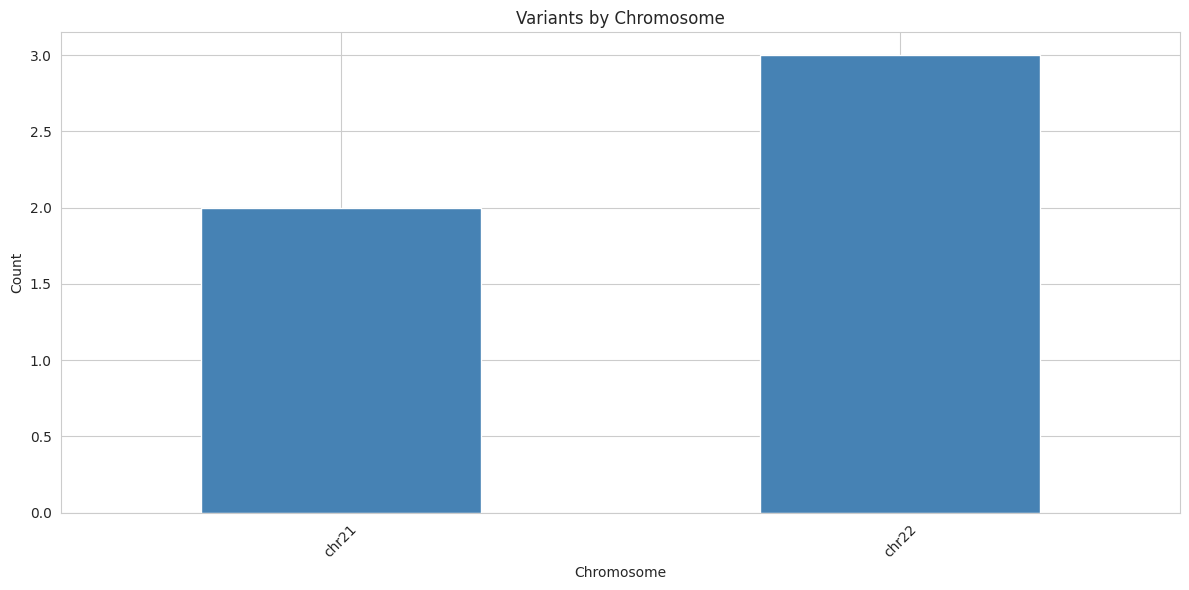

In [9]:
# 创建批量摘要可视化
fig = plot_batch_summary(results_df, metric='success', figsize=(10, 6))

if fig:
    plt.show()

# 染色体分布
fig2 = plot_batch_summary(results_df, metric='chromosome', figsize=(12, 6))
if fig2:
    plt.show()

## 8. 导出结果

In [10]:
# 创建结果目录
results_dir = Path.home() / 'work' / 'results' / 'batch_analysis'
results_dir.mkdir(parents=True, exist_ok=True)

# 导出为 CSV
csv_path = results_dir / 'batch_results.csv'
export_to_csv(results_df, csv_path)
print(f"✓ CSV 已导出: {csv_path}")

# 导出为 Excel
excel_path = results_dir / 'batch_results.xlsx'
export_to_excel(results_df, excel_path)
print(f"✓ Excel 已导出: {excel_path}")

# 保存图表
if fig:
    fig.savefig(results_dir / 'batch_summary.png', dpi=300, bbox_inches='tight')
    print(f"✓ 摘要图表已保存")

if fig2:
    fig2.savefig(results_dir / 'chromosome_distribution.png', dpi=300, bbox_inches='tight')
    print(f"✓ 分布图表已保存")

print(f"\n所有结果已保存到: {results_dir}")

2026-02-09 06:01:28,182 - alphagenome_tools.helpers - INFO - Exported to CSV: /home/admin/work/results/batch_analysis/batch_results.csv


✓ CSV 已导出: /home/admin/work/results/batch_analysis/batch_results.csv


2026-02-09 06:01:28,204 - alphagenome_tools.helpers - INFO - Exported to Excel: /home/admin/work/results/batch_analysis/batch_results.xlsx


✓ Excel 已导出: /home/admin/work/results/batch_analysis/batch_results.xlsx
✓ 摘要图表已保存
✓ 分布图表已保存

所有结果已保存到: /home/admin/work/results/batch_analysis


## 9. 分析成功的预测

In [11]:
# 筛选成功的预测
successful = results_df[results_df['success']].copy()

print(f"正在分析 {len(successful)} 个成功的预测")
print("\n按染色体的摘要统计:")
print(successful.groupby('chromosome').size())

正在分析 5 个成功的预测

按染色体的摘要统计:
chromosome
chr21    2
chr22    3
dtype: int64


## 10. 批量区间分析（可选）

In [12]:
# 您也可以批量分析基因组区间
# 定义要分析的区间
# 注意: 区间必须使用模型支持的长度: 16384, 131072, 524288, 或 1048576

intervals = [
    genome.Interval('chr22', 35677410, 35677410 + 131072),  # 131kb 区间
    genome.Interval('chr22', 36000000, 36000000 + 131072),  # 131kb 区间
    genome.Interval('chr21', 33000000, 33000000 + 131072),  # 131kb 区间
]

print(f"正在对 {len(intervals)} 个区间运行批量序列分析...")

# 运行批量预测
interval_results = batch_predict_sequences(
    intervals=intervals,
    model=model,
    show_progress=True,
    monitor=True
)

print("\n✓ 区间分析完成！")
display(interval_results)

正在对 3 个区间运行批量序列分析...


Predicting sequences: 100%|██████████| 3/3 [00:01<00:00,  1.56it/s]
2026-02-09 06:01:30,460 - alphagenome_tools.helpers - INFO - Completed 3 sequence predictions (3 successful)



✓ 区间分析完成！


,chromosome,start,end,length,success,error,mean_expression,max_expression,data_points
0,chr22,35677410,35808482,131072,True,None,0.058528,5.062500,131072
1,chr22,36000000,36131072,131072,True,None,0.008273,0.765625,131072
2,chr21,33000000,33131072,131072,True,None,0.001115,0.206055,131072


## 总结

在本 notebook 中，您学习了如何:

✓ 准备批量输入数据（CSV 或编程方式）  
✓ 对多个变异运行预测  
✓ 在批量任务期间监控 API 配额  
✓ 可视化批量结果  
✓ 将结果导出为多种格式  

### 最佳实践:
- 从小批量（10-20 个变异）开始测试
- 密切监控 API 配额
- 频繁保存中间结果
- 对长时间运行的任务使用进度跟踪

### 相关 Notebooks:
- **02_variant_analysis.ipynb** - 单个变异分析
- **04_visualization.ipynb** - 高级可视化